## Inicialización

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Carga los datos

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.sample(10)

,file_name,real_age
6114,006117.jpg,18
7238,007256.jpg,18
528,000528.jpg,56
5833,005833.jpg,14
4123,004123.jpg,30
7429,007451.jpg,25
5869,005870.jpg,28
3855,003855.jpg,22
7471,007493.jpg,36
521,000521.jpg,15


In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

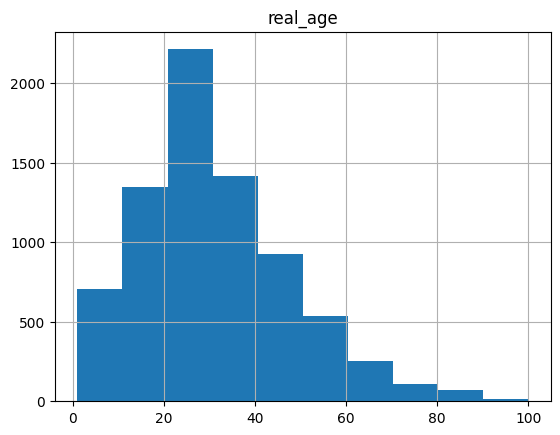

In [6]:
df.hist()

<AxesSubplot:>

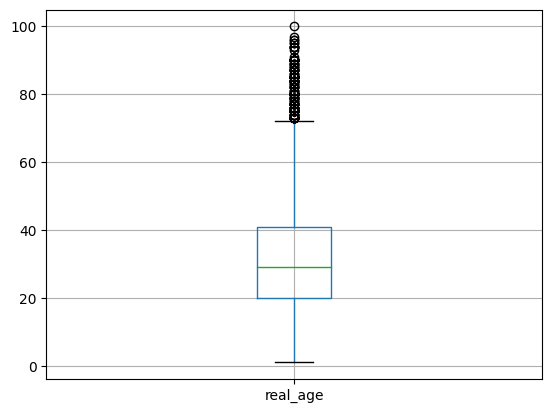

In [7]:
df.boxplot()

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
images, labels = next(train_gen_flow)

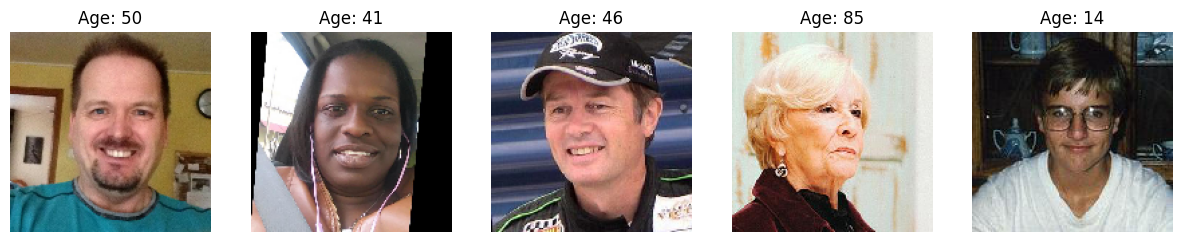

In [11]:
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {labels[i]}')
    plt.axis('off')

plt.show()

### Conclusiones

- Como se pudo ver en el histograma y con la función describe, la mayoría de edad se encuentra alrededor de 30 años, siendo la media = 31.20 y la mediana = 29. Si ampliamos el rango, la mayoría de los datos se encuentra entre 15 y 40 años. 
- En el Boxplot, podemos ver que hay algunos outliers, que son personas de la tercera edad. Sin embargo, son edades muy factibles, por lo que no hay ningún problema.
- Las fotos y las edades se ven congruentes, por lo que se va a proceder a rellenar las funciones y al modelado.

## Modelado

In [12]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta
    """

    # Aumento de datos para el entrenamiento y reescalado general
    data_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # esto permite usar el mismo CSV para training y validation
    )

    data_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',  # para regresión
        subset='training',
        seed=12345
    )

    return data_gen_flow

In [13]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    data_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # Igual que en el entrenamiento
    )

    test_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',       # Como es regresión
        subset='validation',    # Esta es la clave para test
        seed=12345
    )

    return test_gen_flow

In [14]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)  
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

In [16]:
# Ejecucion de las funciones load_train y load_test para confirmar que el split se haya hecho correctamente
train_data = load_train('/datasets/faces/')
test_data = load_test('/datasets/faces/')
test_images, test_labels = next(test_data)
train_images, train_labels = next(train_data)

Found 6073 validated image filenames.
Found 1518 validated image filenames.


## Preparar el script

In [17]:

# Script

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Funciones

def load_data(path, subset='training'):
    labels = pd.read_csv(path + 'labels.csv')
    
    data_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255
    )
    
    data_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset=subset,
        seed=12345
    )
    
    return data_gen_flow

def load_train(path):
    return load_data(path, subset='training')

def load_test(path):
    return load_data(path, subset='validation')

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))  # ReLU para evitar edades negativas

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model
"""

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')


### El resultado

El script se ejecutó en otro entorno, dando un resultado Test MAE de 7.3602


## Conclusiones

El resultado final del MAE es de 7.36, mejor que el mínimo aceptable de 8. Lo que significa que el modelo funciona y predice las edades de las personas correctamente. 